In [1]:
import hyperimp.evaluate.importance as hyperimp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load rank data

# load accuracy data

# Compute risk scores
fixed = [0.21, 0.31, 0.45]
non_fixed = [0.20, 0.30, 0.40]

# Average rank

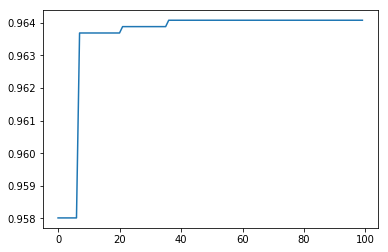

In [8]:
import openml
trace = openml.runs.get_run_trace(9193667)
val_scores = hyperimp.get_val_scores(trace)

# Tunability


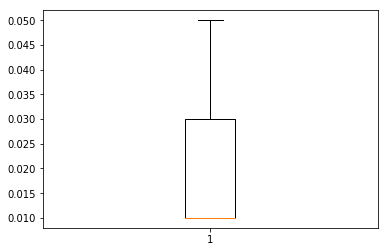

Average tunability: 0.02


In [3]:
scores, average = hyperimp.tunability(fixed, non_fixed)
plt.boxplot(scores)
plt.show()
print("Average tunability: %.2f" % average)

Average relative tunability: 0.07


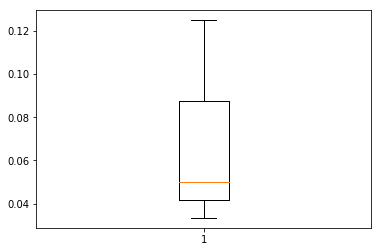

In [4]:
scores, average = hyperimp.relative_tunability(fixed, non_fixed)
print("Average relative tunability: %.2f" % average)
plt.boxplot(scores)
plt.show()

# Non-inferiority

In [5]:
delta = 0.10
alpha = 0.05

fixed = [0.201, 0.31, 0.4, 0.3, 0.3, 0.3, 0.3 ,0.3 ,0.3 ,0.3]
non_fixed = [0.20, 0.30, 0.40, 0.31,0.31,0.31,0.31,0.31,0.31,0.31 ]
hyperimp.noninferior(fixed, non_fixed, delta, alpha)

(2.8030595529069404, 0.002531016063133932)